In [244]:
#adding more layers to the ANN 
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.inspection import permutation_importance

In [246]:
df = pd.read_csv('CellShapeR-tidy2.csv')
df.head()

,group,circ,solidity
0,3,0.65953,0.95660
1,3,0.31968,0.94069
2,3,0.31968,0.94069
3,1,0.56353,0.93737
4,3,0.27930,0.92852


In [248]:
na_counts = df.isna().sum()
print(na_counts)

group       0
circ        0
solidity    0
dtype: int64


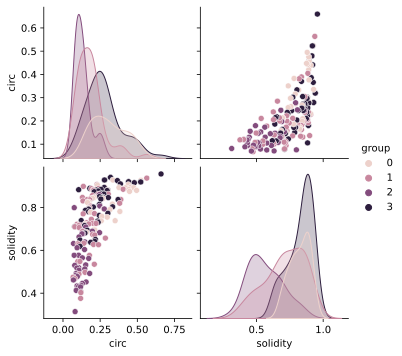

In [250]:
sns.pairplot(df, hue='group')
plt.show()

In [262]:
# convert from pandas dataframe to tensor
data = torch.tensor(df[df.columns[1:3]].values).float()
codedlabels = df['group'].values
# transform categorical to number
labels = torch.tensor(codedlabels, dtype=torch.long)
#labels[df.group=='PRDWT'] = 0
#labels[df.group=='PRDNULL'] = 1
#labels[df.group=='KO'] = 2
#labels[df.group=='WT'] = 3
labels

tensor([3, 3, 3, 1, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 0, 3, 0, 3,
        0, 0, 0, 3, 3, 1, 1, 1, 3, 0, 3, 1, 3, 3, 1, 0, 0, 3, 3, 0, 3, 3, 3, 1,
        3, 1, 2, 1, 3, 1, 3, 3, 0, 3, 3, 1, 0, 0, 3, 1, 3, 1, 1, 1, 0, 0, 1, 0,
        3, 2, 1, 3, 3, 1, 2, 0, 0, 2, 3, 0, 3, 0, 3, 0, 3, 1, 1, 3, 0, 0, 1, 3,
        0, 0, 3, 3, 1, 1, 1, 0, 1, 1, 1, 3, 1, 3, 1, 2, 1, 0, 0, 3, 2, 2, 1, 0,
        2, 3, 2, 2, 1, 1, 2, 1, 3, 3, 3, 2, 3, 1, 2, 1, 1, 1, 1, 3, 2, 2, 2, 2,
        1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
        1, 2, 2, 2, 2, 2, 1, 1, 2])

In [264]:
# model architecture
ANNwave = nn.Sequential(
    nn.Linear(2,16),   # input layers circ solidity
    nn.ReLU(),         # activation
    nn.Linear(16,16),  # hidden layer
    nn.ReLU(),         # activation
    nn.Linear(16,4),   # output layer group
      )

# loss function
lossfun = nn.CrossEntropyLoss()  #also computes softmax

# optimizer
optimizer = torch.optim.SGD(ANNwave.parameters(),lr=.25)

In [266]:
numepochs = 2000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochs in range(numepochs):

  # forward pass
  yHat = ANNwave(data)

  # compute loss
  loss = lossfun(yHat,labels)
  losses[epochs] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # compute accuracy
  matches = torch.argmax(yHat,axis=1) == labels # booleans (false/true)
  matchesNumeric = matches.float()              # convert to numbers (0/1)
  accuracyPct = 100*torch.mean(matchesNumeric)  # average and x100
  ongoingAcc.append( accuracyPct )              # add to list of accuracies
    
# final forward pass
predictions = ANNwave(data)

predlabels = torch.argmax(predictions,axis=1)
totalacc = 100*torch.mean((predlabels == labels).float())

In [268]:
torch.argmax(yHat,axis=1)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 0, 3,
        3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 0, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1,
        0, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2])

Final accuracy: 50.8475%


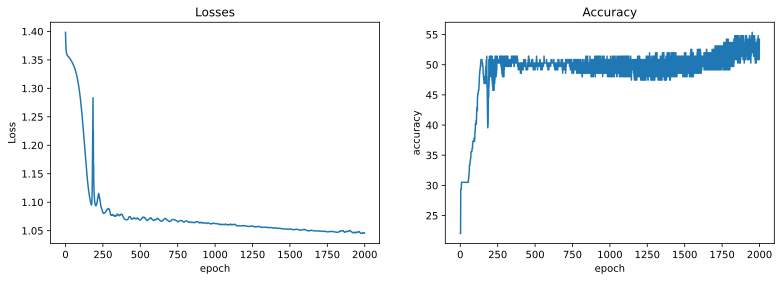

In [270]:
# accuracy
print('Final accuracy: %g%%' %totalacc)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()

In [272]:
sm = nn.Softmax(1)
torch.sum(sm(yHat),axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

<Figure size 800x600 with 0 Axes>

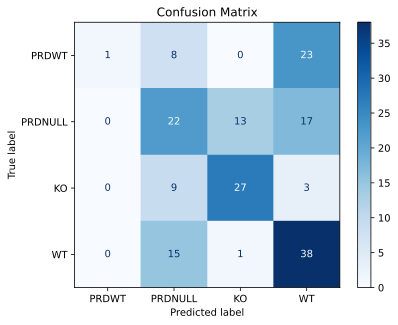

In [274]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_np, predictions_np)
class_names = ['PRDWT', 'PRDNULL', 'KO', 'WT']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer values
plt.title('Confusion Matrix')
plt.show()